# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import stats
import numpy as np
import math
import cv2
import os

## Helper Classes


I took an Object Oriented Approach to the project and thus created extra abstractions to help facilate how I thought about achieving what needed to be accomplished. The `Point` class is just a simple wrapper around an `(x, y)` coordinate pair that provides some useful functionality to make it easier to work with coordinates. The class also provides a `slope` method to calculate the slope between two `Point` instances. 

In [119]:
class Point:
    """Abstraction for an (x, y) coordinate pair

    # Arguments:
        x: any integer or floating point number
        y: any integer or floating point number

    # Example:

    ```python

        # Instantiate some points
        >>> point = Point(3, 5)
        >>> another_point = Point(7, 10)
        >>> point()
        (3, 5)

        # Calculate the slope between two points
        >>> slope = Point.slope(point, another_point)
        >>> slope
        1.25

    ```
    """
    def __init__(self, x, y):
        self._x = x
        self._y = y

    def __call__(self):
        """Returns a tuple containt an (x, y) pair"""
        return (self.x, self.y)

    @staticmethod
    def slope(one, two):
        """Calculate the slope between two Point instances

        # Arguments:
            one: instance of Point
            two: instance of Point

        # Returns:
            The slope between two points. If the delta between
            the `x` coordinates is inf, nan, or 0.0, returns 0.0
        """
        x_delta = np.subtract(two.x, one.x, dtype=np.float32)
        if x_delta in {np.nan, np.inf, np.float32(0)}:
            return np.float32(0)
        y_delta = np.subtract(two.y, one.y)

        return np.divide(y_delta, x_delta, dtype=np.float32)

    @property
    def x(self):
        """Returns x coordinate"""
        return self._x

    @property
    def y(self):
        """Returns y coordinate"""
        return self._y

In [120]:
class Lane:
    """Abstraction for a lane

    A lane is composed of a bunch of small lines represented by (x1, y1)
    and (x2, y2) coordinate pairs.

    # Arguments:
        _points: list of Point instances
        min_x: threshold for the smallest x value that the lane can contain.
        max_x: threshold for the largest x value that the lane can contain.
            This is useful for filtering out lines that do not fall into a
            a specific window that we have specified.

    # Example:

        # Create an instance of a Lane
        >>> left = Lane(min_x=0, max_x=100)
        >>> point = Point(4, 4)
        >>> another_point = Point(120, 3)

        # Add the points to the Lane
        >>> left.points = [point, another_point]

        # Only one point is added since the second point
        # was beyond the threshold (120 > 100).
        >>> left.points
        [<__main__.Point at 0x1155ae240>]

    """
    def __init__(self, min_x, max_x):
        self._points = []
        self.min_x = min_x
        self.max_x = max_x

    @property
    def points(self):
        """Returns all the points in the lane"""
        return self._points

    @points.setter
    def points(self, points):
        """Add points to the lane

        The points are only added if they fall within the boundary
        specified by `min_x` and `max_x`.

        # Returns:
            None
        """
        for point in points:
            if np.greater(point.x, self.min_x) and np.less(point.x, self.max_x):
                self._points.append(point)
            else:
                continue

        return None

    @property
    def xs(self):
        """Return all x values for the points stored in the Lane

        # Example:

            >>> lane = Lane(0, 10)
            >>> lane.points = [Point(1, 2), Point(3, 4)]

            >>> lane.xs
            [1, 3]

        """
        return [point.x for point in self.points]

    @property
    def ys(self):
        """Return all x values for the points stored in the Lane

        # Example:

            >>> lane = Lane(0, 10)
            >>> lane.points = [Point(1, 2), Point(3, 4)]

            >>> lane.ys
            [2, 4]

        # Returns:
            A list of integers
        """
        return [point.y for point in self.points]

    def fit(self, dimension=1):
        """Fits a line to the points in the lane

        Given a list of x-coordinates and y-coordinates,
        will fit a line that runs through those points.

        Returns:
            Two tuples representing the starting and ending vertices
            of the line to draw.
        """
        slope, intercept = np.polyfit(self.xs, self.ys, dimension)
        function = np.poly1d([slope, intercept])
        
        # If the smallest `x` value in the lane is less than the `max_x` threshold, 
        # the `x` value will be used as the starting vertex. Otherwise, the threshold
        # as defined by `self.min_x` will be used to draw the line. 
        left_min = min(min(self.xs), self.min_x)
        # Same thing as above applies to the largest `x` value. If the `x` value is above 
        # the max threshold, it will will be used. Otherwise, `self.max_x` is used as the 
        # maximum threshold.
        right_max = max((max(self.xs)), self.max_x)

        one = left_min, int(function(left_min))
        two = right_max, int(function(right_max))

        return (one, two)

## Lane Finding Pipeline



The `Pipeline` class is yet another abstraction that I build that does most of the work. I was inspired by the way that the `Keras` library wrote their APIs and took a similar approach when I was writing the code. To summarize, images and layers are fed into the pipeline that does all of processing. A layer in this case is just a transformation, like grayscaling an image or applying a Hough transform. 

In [257]:
class Pipeline:
    """Abstraction for the pipeline

    The pipeline contains the layers that apply the various
    transformations on the images.

    # Arguments:
        layers: list of instance of transformation classes
        images: list of numpy representations of the images

    # Example:

        >>> pipeline = Pipeline()
        # This doesn't actually work but used for illustrative purposes :) 
        >>> pipeline.add(Image(path='some/path/to/image')) 

        # The pipeline can now apply a grayscale transformation
        # to the images in the pipline.
        >>> pipeline.add(Gray())

        # Applies all the transformations in `layers` to `images`.
        >>>> pipeline.run()

    """
    def __init__(self):
        self.layers = []
        self.images = []

    def add(self, layer):
        """Adds a layer to the pipeline"""
        return self.layers.append(layer)

    def add_images(self, images, base_path='test_images/', single_image=False, array=False):
        """Adds a single image or batch of images to the pipeline.

        # Arguments:
            array: if True, will directly add the numpy image array to the pipeline.
        """

        if array:
            self.images.append(images)
            return images

        if type(images) is not list:
            images = list(images)

        for path in images:
            image = mpimg.imread(base_path + path)
            self.images.append(image)

        if single_image:
            return self.images[0]


    def run(self, single_image=False):
        """Applies the transformations to the images in the pipeline

        # Arguments:
            single_image: if True, will run the transformations only
                on one image. If there are multiple images in the pipeline,
                it will the first one.
        """
        if not single_image:
            for index, image in enumerate(self.images):
                initial_image = image

                for layer in self.layers:
                    image = layer(image, initial_image=initial_image, key=index)
        else:
            image = self.images[0]
            initial_image = image
            for layer in self.layers:
                image = layer(image, initial_image=initial_image)
            return image


## Transformation Abstractions

These classes are just fancier abstractions around the helper functions that were provided with the project. 

In [122]:
class Gray:
    """Grayscales an image

    # Arguments:
        save: if True, writes the image to disk

    # Returns:
        A grayscaled image
    """
    def __call__(self, image, save=True, **kwargs):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        if save and 'key' in kwargs:
            mpimg.imsave(f"test_images_output/image-{kwargs['key']}/gray.jpg", image, cmap="gray")
        return image

In [123]:
class Gaussian:
    """Applies Gaussian blurring

    # Arguments:
        kernel_size: how blurry the image should be. Must be an odd integer.
    """
    def __init__(self, kernel_size=3):
        if kernel_size is not 1 and kernel_size % 2 == 0:
            raise ValueError('`kernel_size` must be an odd number')
        self.kernel_size = kernel_size

    def __call__(self, image, save=True, **kwargs):
        image = cv2.GaussianBlur(image, (self.kernel_size, self.kernel_size), 0)
        if save and 'key' in kwargs:
            mpimg.imsave(f"test_images_output/image-{kwargs['key']}/blur.jpg", image, cmap='gray')
        return image

In [143]:
class Canny:
    """Applies Canny edge detection transform"""
    def __init__(self, low_threshold=50, high_threshold=150):
        self.low_threshold = low_threshold
        self.high_threshold = high_threshold

    def __call__(self, image, save=True, **kwargs):
        image = cv2.Canny(image, self.low_threshold, self.high_threshold)
        if save and 'key' in kwargs:
            mpimg.imsave(f"test_images_output/image-{kwargs['key']}/canny.jpg", image, cmap='gray')
        return image

In [200]:
class Region:
    """Applies a mask to an image as defined by vertices

    # Arguments:
        vertices: numpy 2D array of vertices of a polygon

    # Returns:
        The image with the mask applied.
    """
    def __init__(self, vertices):
        self.vertices = vertices

    def __call__(self, image, save=True, **kwargs):
        mask = np.zeros_like(image)

        if len(image.shape) > 2:
            channel_count = image.shape[2]
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        cv2.fillPoly(mask, self.vertices, ignore_mask_color)

        image = cv2.bitwise_and(image, mask)
        if save and 'key' in kwargs:
            mpimg.imsave(f"test_images_output/image-{kwargs['key']}/region.jpg", image, cmap='gray')
        return image

In [201]:
class HoughTransform:
    """Applies the Hough transform"""
    def __init__(self, rho=2, theta=np.pi/180, threshold=1, min_line_len=5, max_line_gap=30, extrapolate=False):
        self.rho = rho
        self.theta = theta
        self.threshold = threshold
        self.min_line_len = min_line_len
        self.max_line_gap = max_line_gap
        self.extrapolate = extrapolate

    def __call__(self, image, **kwargs):
        self.kwargs = kwargs
        lines = cv2.HoughLinesP(image, self.rho, self.theta, self.threshold, np.array([]),
                                minLineLength=self.min_line_len, maxLineGap=self.max_line_gap)
        line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        if self.extrapolate:
            self.draw_extrapolated_lines(line_img, lines)
        else:
            self.draw_lines(line_img, lines)

        return line_img

    def draw_lines(self, img, lines, color=[255, 0, 0], thickness=2):
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    def draw_extrapolated_lines(self, image, lines, color=[255, 0, 0], thickness=10, save=False):
        """This is where the magic happens!

        # Arguments:
            image: image to apply the transform on
            lines: Hough lines generated by cv2.HoughLinesP
            color: RGB value of line color
            thickness: thickness of line
            save: if True, saves the image to disk

        # Returns:
            Image with extrapolated lines drawn
        """
        left_lane = Lane(min_x=100, max_x=450)
        right_lane = Lane(min_x=505, max_x=940)

        for line in lines:
            for x1,y1,x2,y2 in line:
                one, two = np.array([Point(x1, y1), Point(x2, y2)])
                slope = Point.slope(one, two)

                # In an image coordinate system, (0, 0) is in the top left
                # corner and thus a positive slope in the Cartesian plane
                # will actually have a negative slope in the image coordinate system.
                if slope < 0:
                    left_lane.points = [one, two]
                if slope > 0:
                    right_lane.points = [one, two]

        # Fit the points in the lines to get the vertices to draw the extrapolated lines
        start_one, end_one = left_lane.fit()
        start_two, end_two = right_lane.fit()

        # Draw the left and right lane lines.
        cv2.line(image, start_one, end_one, color, thickness)
        cv2.line(image, start_two, end_two, color, thickness)

        if save and 'key' in self.kwargs:
            mpimg.imsave(f"test_images_output/image-{self.kwargs['key']}/hough.jpg", image)

        return image

In [216]:
class WeightMask:
    """Applies the extrapolated lines to the original image"""
    def __call__(self, image, α=0.8, β=1., λ=0, save=False, **kwargs):
        image = cv2.addWeighted(kwargs['initial_image'], α, image, β, λ)
        if save and 'key' in kwargs:
            mpimg.imsave(f"test_images_output/image-{kwargs['key']}/final.jpg", image)
        return image

## Instantiate the Pipeline

Note about running the pipeline: to get the proper output for each cell, you must rerun all previous cells since the pipeline is designed to worked in a sequential order and rerunning a cell can cause errors unless you run the previous cells. 

In [240]:
pipeline = Pipeline()

## Add an Image to the Pipeline

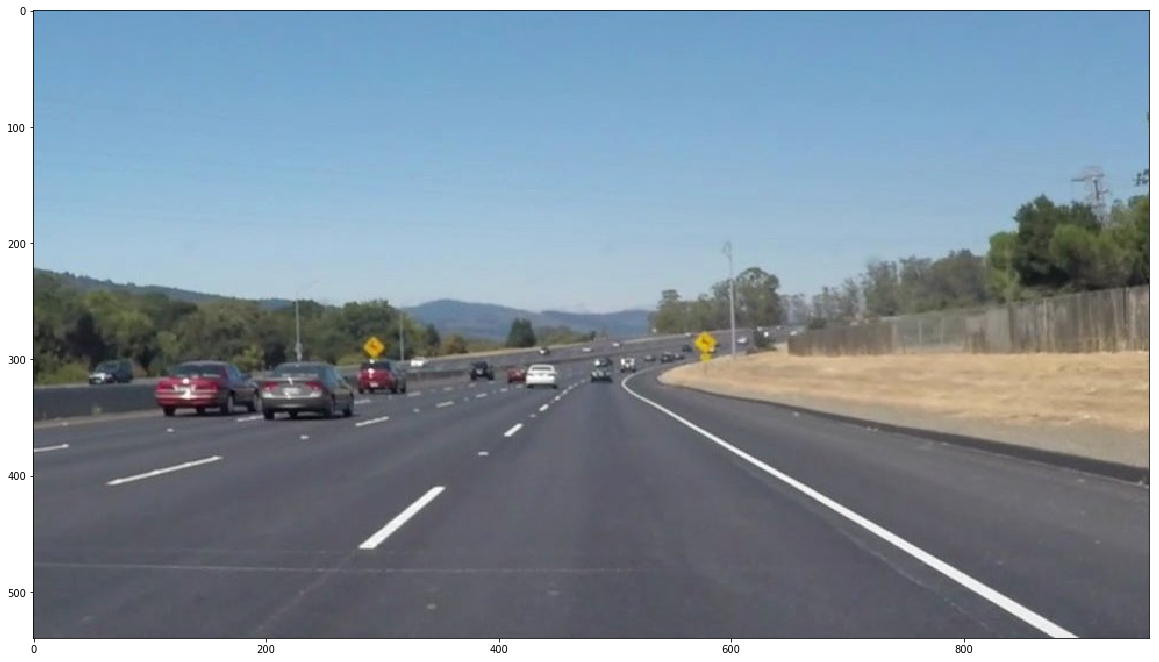

In [241]:
image_paths = ["solidWhiteCurve.jpg"]

image = pipeline.add_images(image_paths, single_image=True)

# Display our image
plt.figure(figsize=(20, 20))
plt.imshow(image)

## Grayscale the Image

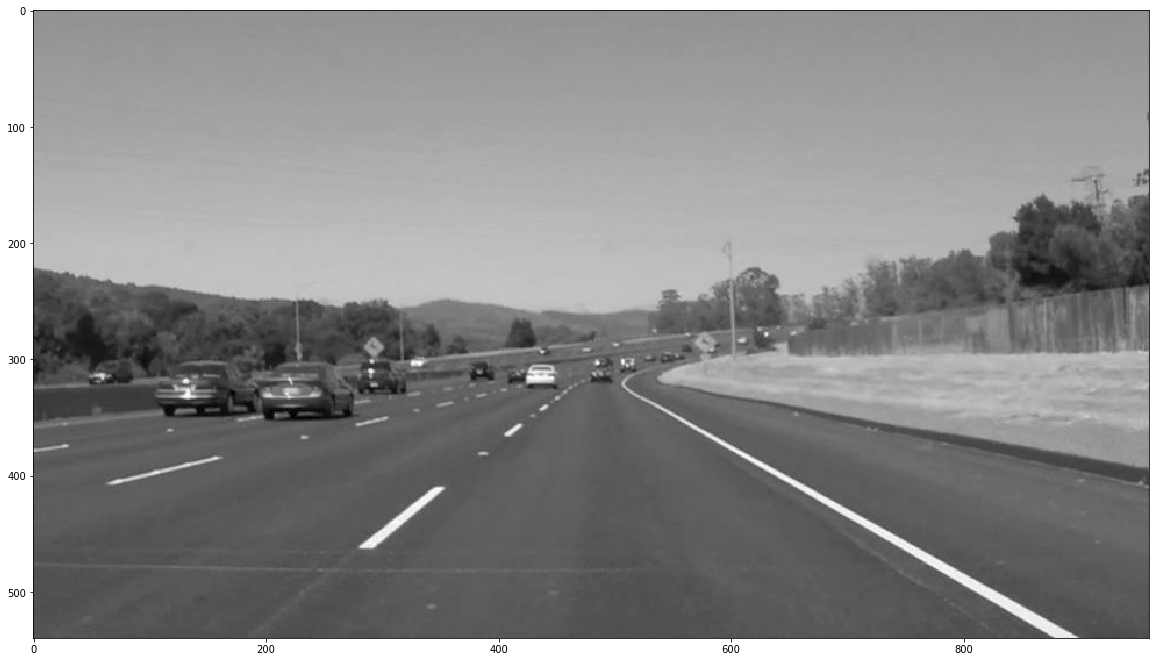

In [242]:
pipeline.add(Gray())
image = pipeline.run(single_image=True)

# Display our image
plt.figure(figsize=(20, 20))
plt.imshow(image, cmap='gray')

## Apply a Gaussian Blur

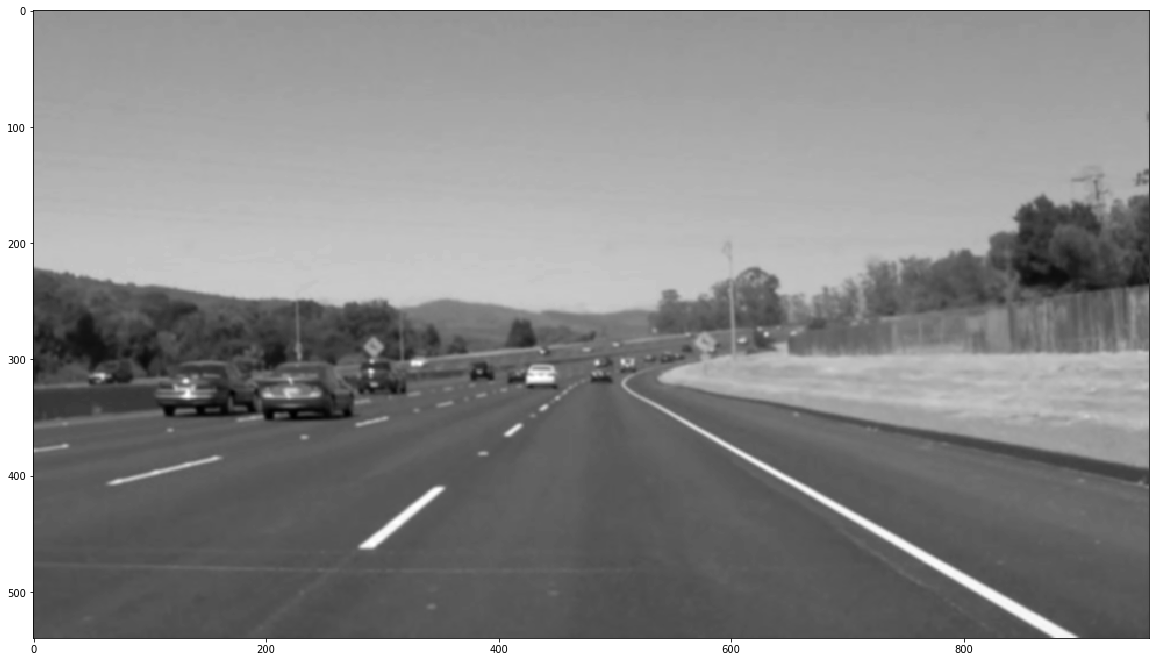

In [243]:
pipeline.add(Gaussian(kernel_size=5))
image = pipeline.run(single_image=True)

# Display our image
plt.figure(figsize=(20, 20))
plt.imshow(image, cmap='gray')

## Apply Canny Edge Detection

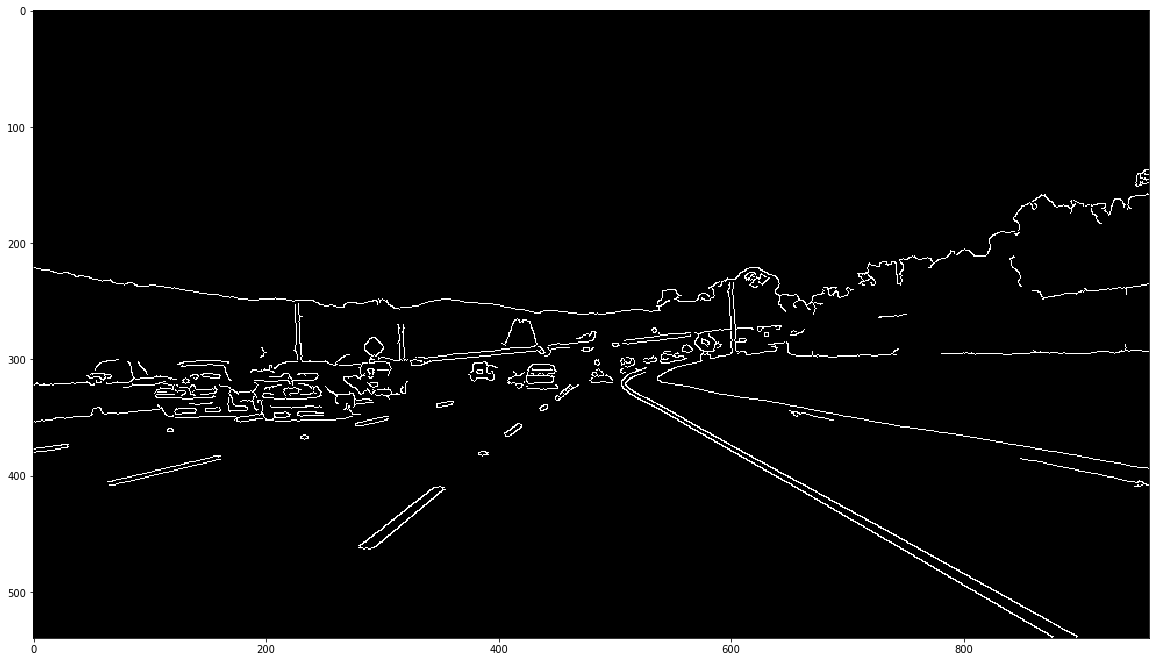

In [244]:
pipeline.add(Canny())
image = pipeline.run(single_image=True)

# Display our image
plt.figure(figsize=(20, 20))
plt.imshow(image, cmap='gray')

## Apply Mask to Region of Interest

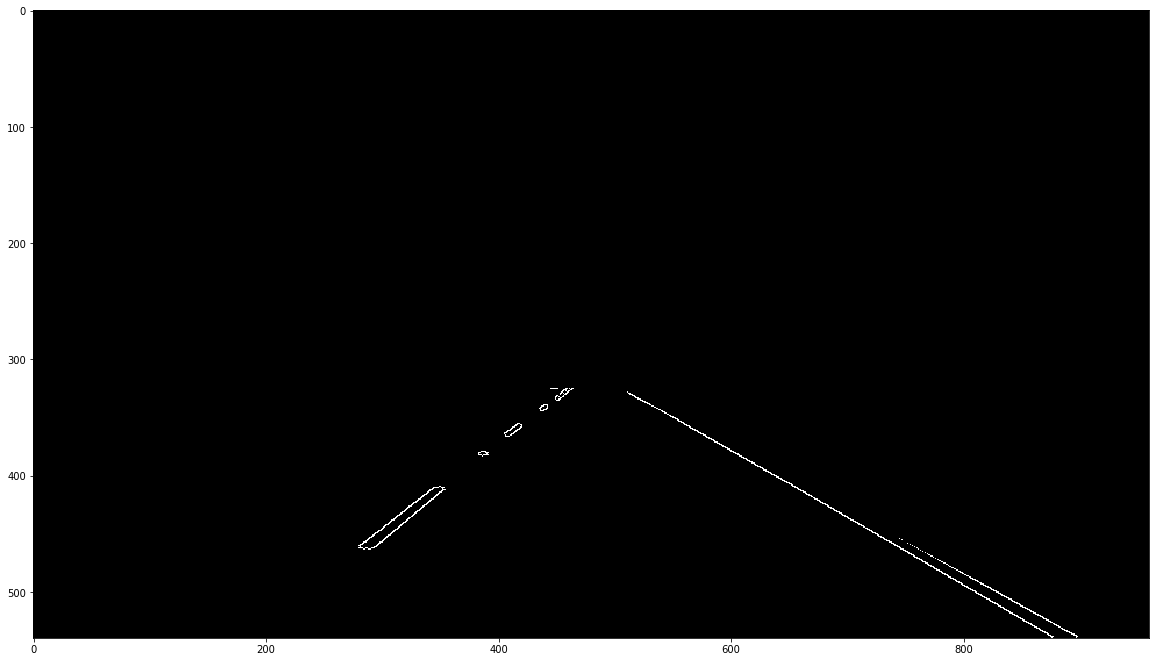

In [245]:
pipeline.add(Region(vertices=np.array([[[100, 560], [445, 325], [505, 325], [940, 560]]])))
image = pipeline.run(single_image=True)

# Display our image
plt.figure(figsize=(20, 20))
plt.imshow(image, cmap='gray')

## Apply Original Hough Transform

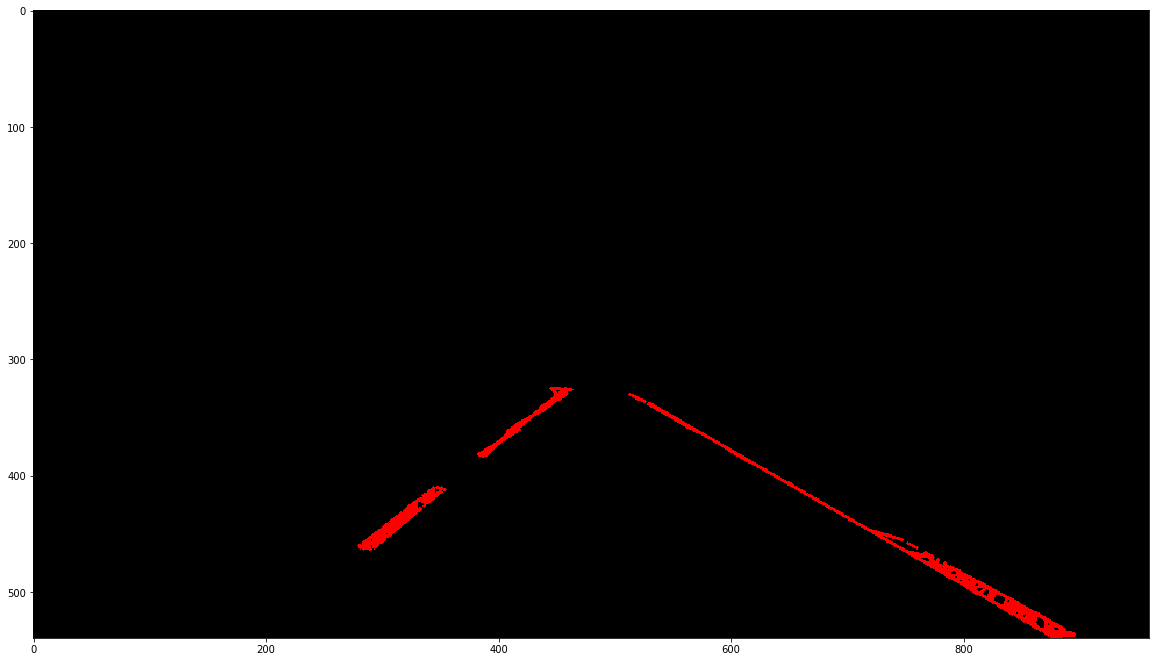

In [223]:
pipeline.add(HoughTransform())
image = pipeline.run(single_image=True)

# Display our image
plt.figure(figsize=(20, 20))
plt.imshow(image, cmap='gray')

## Apply Extrapolated Hough Transform

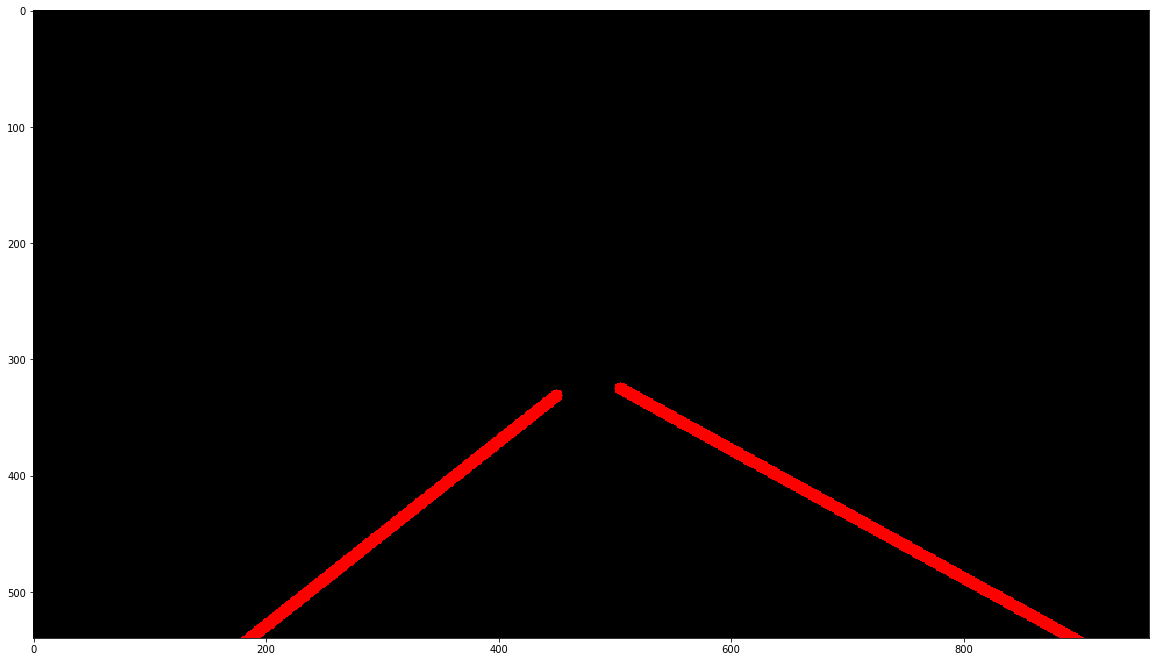

In [246]:
pipeline.add(HoughTransform(extrapolate=True))
image = pipeline.run(single_image=True)

# Display our image
plt.figure(figsize=(20, 20))
plt.imshow(image, cmap='gray')

## Apply Extrapolated Lines to Original Image

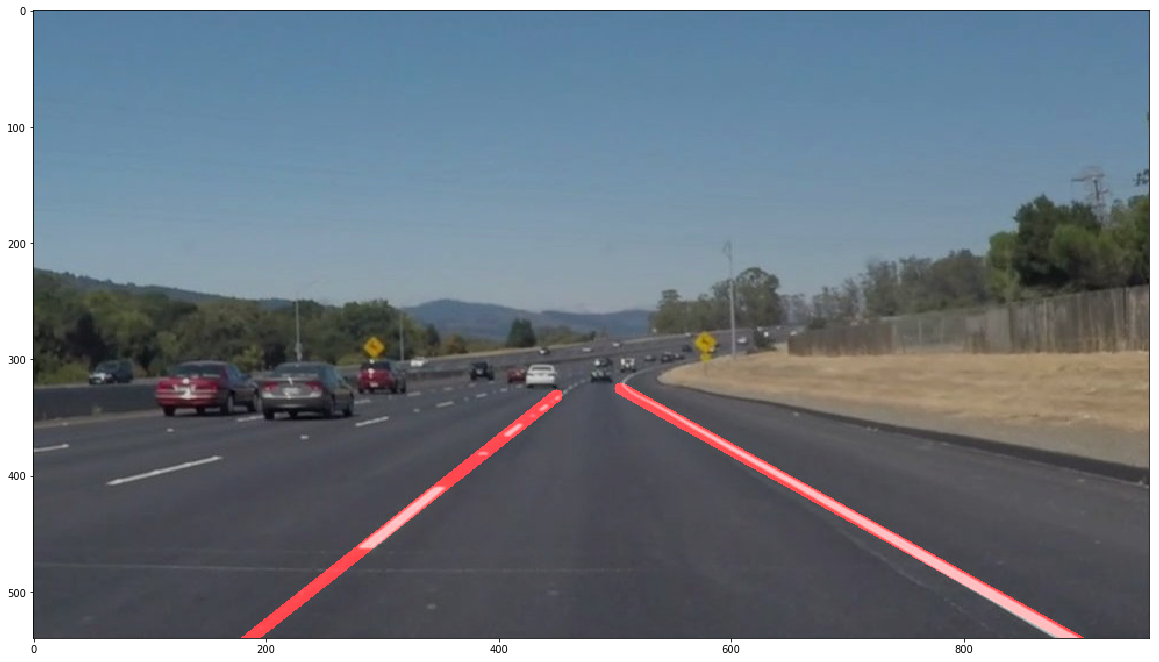

In [247]:
pipeline.add(WeightMask())
image = pipeline.run(single_image=True)

# Display our image
plt.figure(figsize=(20, 20))
plt.imshow(image, cmap='gray')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [251]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [258]:
def process_image(img):
    pipeline = Pipeline()
    pipeline.add_images(img, array=True)
    pipeline.add(Gray())
    pipeline.add(Gaussian(kernel_size=5))
    pipeline.add(Canny())
    pipeline.add(Region(vertices=np.array([[[100, 560], [445, 325], [505, 325], [940, 560]]])))
    pipeline.add(HoughTransform(extrapolate=True))
    pipeline.add(WeightMask())

    output_image = pipeline.run(single_image=True)
    return output_image

Let's try the one with the solid white lane on the right first ...

In [259]:
white_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:12<00:00, 57.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 12.3 s, sys: 754 ms, total: 13 s
Wall time: 12.7 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [260]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [261]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:12<00:00, 55.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 12.3 s, sys: 786 ms, total: 13.1 s
Wall time: 12.7 s


In [263]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [264]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:10<00:00, 24.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 10.7 s, sys: 522 ms, total: 11.2 s
Wall time: 11.1 s


In [265]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))